<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Fourier Analysis</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import datetime

import numpy as np
import pandas as pd

from numpy import fft

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

watermark 2.0.2
numpy     1.18.1
json      2.0.9
pandas    1.0.1
autopep8  1.5
Sat Mar 07 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 1bdd5568a391671cde7739fe958e8b0ce1c67b58


Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Generate some fake data

In [4]:
t_max = 4 # signal duration (seconds)
sample_freq = 250 # points per second
N = t_max*sample_freq
t = np.linspace(0, t_max, N)
amp = np.array([1, .3, .1])
freq = np.array([1, 2, 10])

We can combine the individual components into a total signal.

In [5]:
def build_signal(amp, freq, t):
    total = np.zeros(len(t))
    components = []

    n_freq = len(freq)

    for i in range(n_freq):
        current = amp[i]*np.cos(2*np.pi*freq[i]*t)
        total += current

        components.append(current)
    
    return total, components

As we know that all the components are real, we don't need to worry about the phase component

In [6]:
total, components = build_signal(amp, freq, t)

And plot the result of the whole process

In [7]:
for i, comp in enumerate(components):
    plt.plot(t, comp, label="f=%g" % freq[i], lw=1)

plt.plot(t, total, label='total')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

Get the color cycle

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 3D visualization

With this simple example, we can also vizualize in 3D to provide a clearer picture of the relationship between time and frequency domain.

(0, 12)

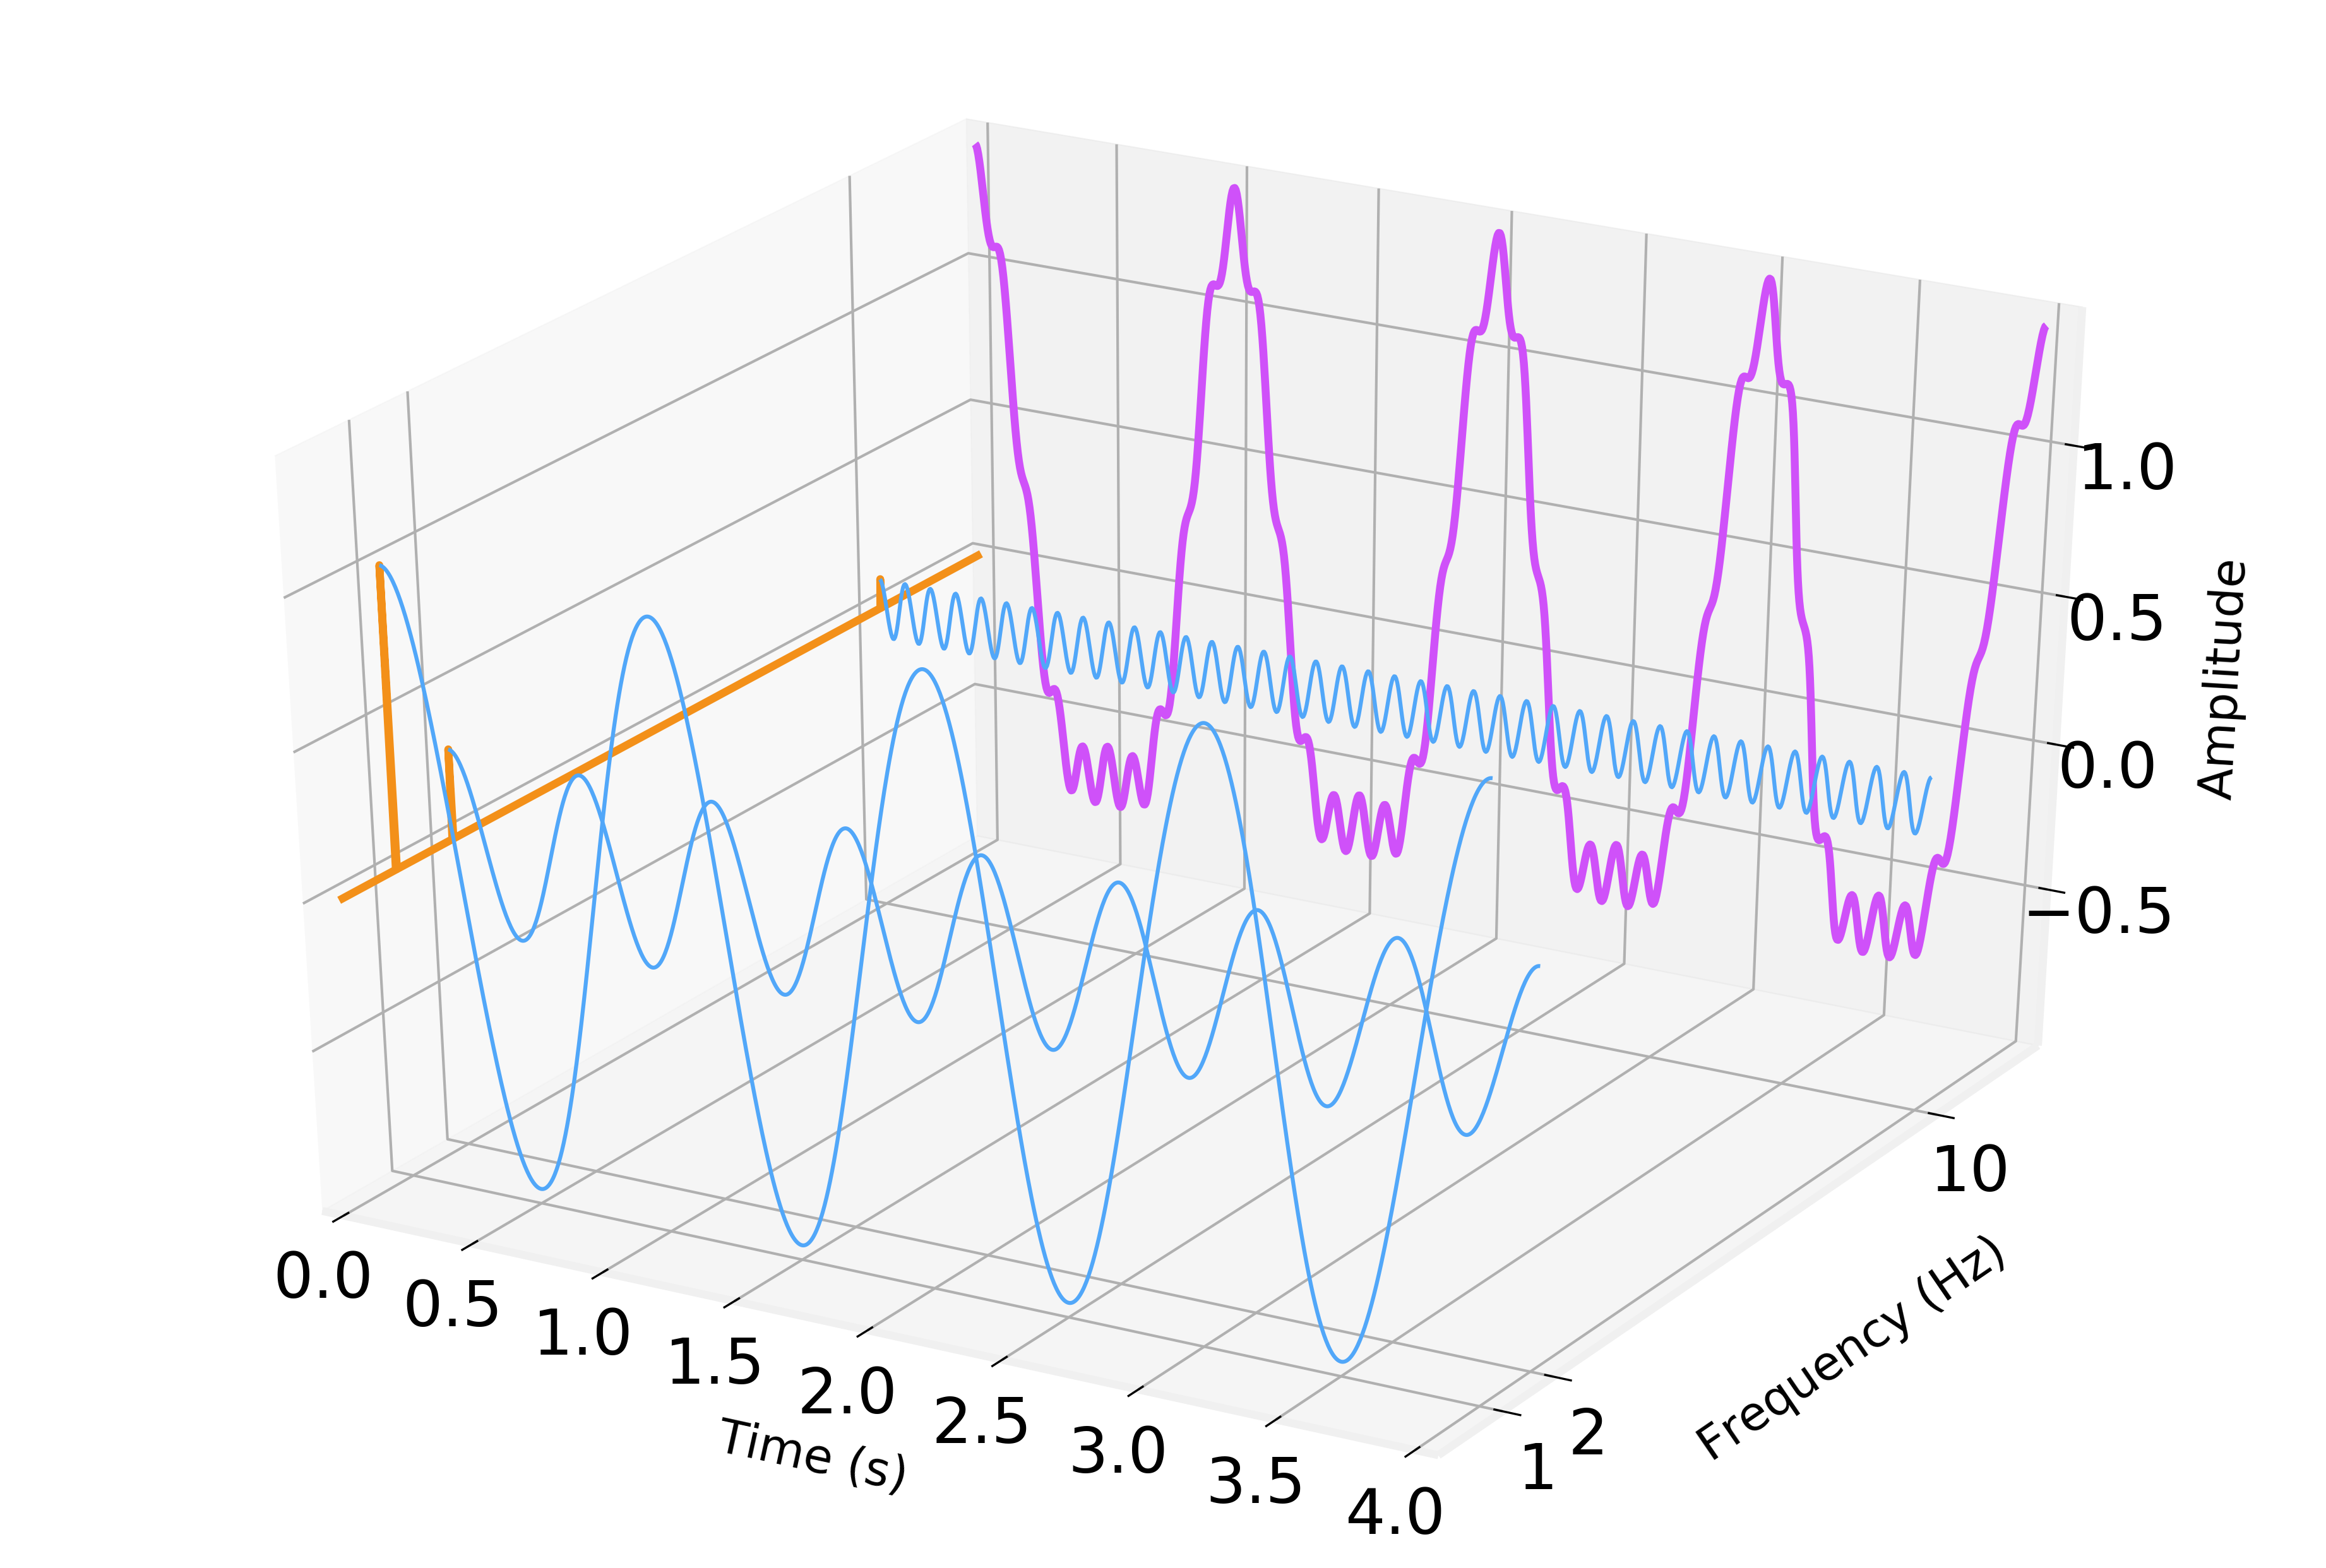

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\n\nTime (s)", fontsize=18)
ax.set_ylabel("\n\nFrequency (Hz)", fontsize=18)
ax.set_zlabel("\n\nAmplitude", fontsize=18)

linewidth = 1

n_freq = np.max(freq)+2
x = np.linspace(0,4,1000)
y = np.ones(x.size)

# Plot the total signal
ax.plot(x, y*n_freq, total, linewidth=3, color=colors[1])

# Plot the amplitudes
z = np.zeros(n_freq*100)
z[freq*100] = amp

ax.plot(np.zeros(n_freq*100), np.linspace(0, n_freq, n_freq*100), z, linewidth=3, color=colors[3])

# Plot the components
y = np.ones(1000)
for i in range(0, len(components)):
    ax.plot(x, y*freq[i], components[i], linewidth=1.5, color=colors[0])
    
ax.set_yticks(freq)
ax.set_yticklabels(freq)
ax.set_xlim(0, t_max)
ax.set_ylim(0, n_freq)

This makes it clear how the observed signal corresponds to the addition of all the components and how each components is defined entirely by it's frequency and amplitude

## FFT to decompose a signal

Perhaps more importantly, this process is also reversible. We can also recover the frequencies and amplitudes from **any** signal, by taking the Fourier transform. Numpy makes it easy

In [10]:
fft_values = fft.fft(total)

The result is an array of complex numbers

In [11]:
fft_values.dtype

dtype('complex128')

To recover the real component of the signal, we simply take the absolute value. The imaginary components corresponds to phase information

In [12]:
fft_real = 2.0/N * np.abs(fft_values[0:N//2])

We see that only a few values are significantly different from zero:

In [13]:
np.where(fft_real>0.01)

(array([ 4,  8, 40]),)

To properly recover the corresponding freqency values, we must calculate the freqency resolution

In [14]:
freq_resolution = sample_freq/N

This is the value we need to convert indices into frequencies

In [15]:
freq_values = np.arange(N)*freq_resolution

So now we can plot the recovered amplitudes with the matching frequencies. For clarity, we plot only the first 50 values and the compare with the original input values

In [16]:
plt.plot(freq_values[:50], fft_real[:50], label='calculated')
plt.scatter(freq, amp, s=100, color=colors[1], zorder=3, label='original')
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.legend()

## FFT in the ILI dataset

In [17]:
ILI = pd.read_csv('data/CDC.csv')
ILI['date'] = ILI['Year']+ILI['Week']/52.

Visualize it

Text(0, 0.5, '% Mortality')

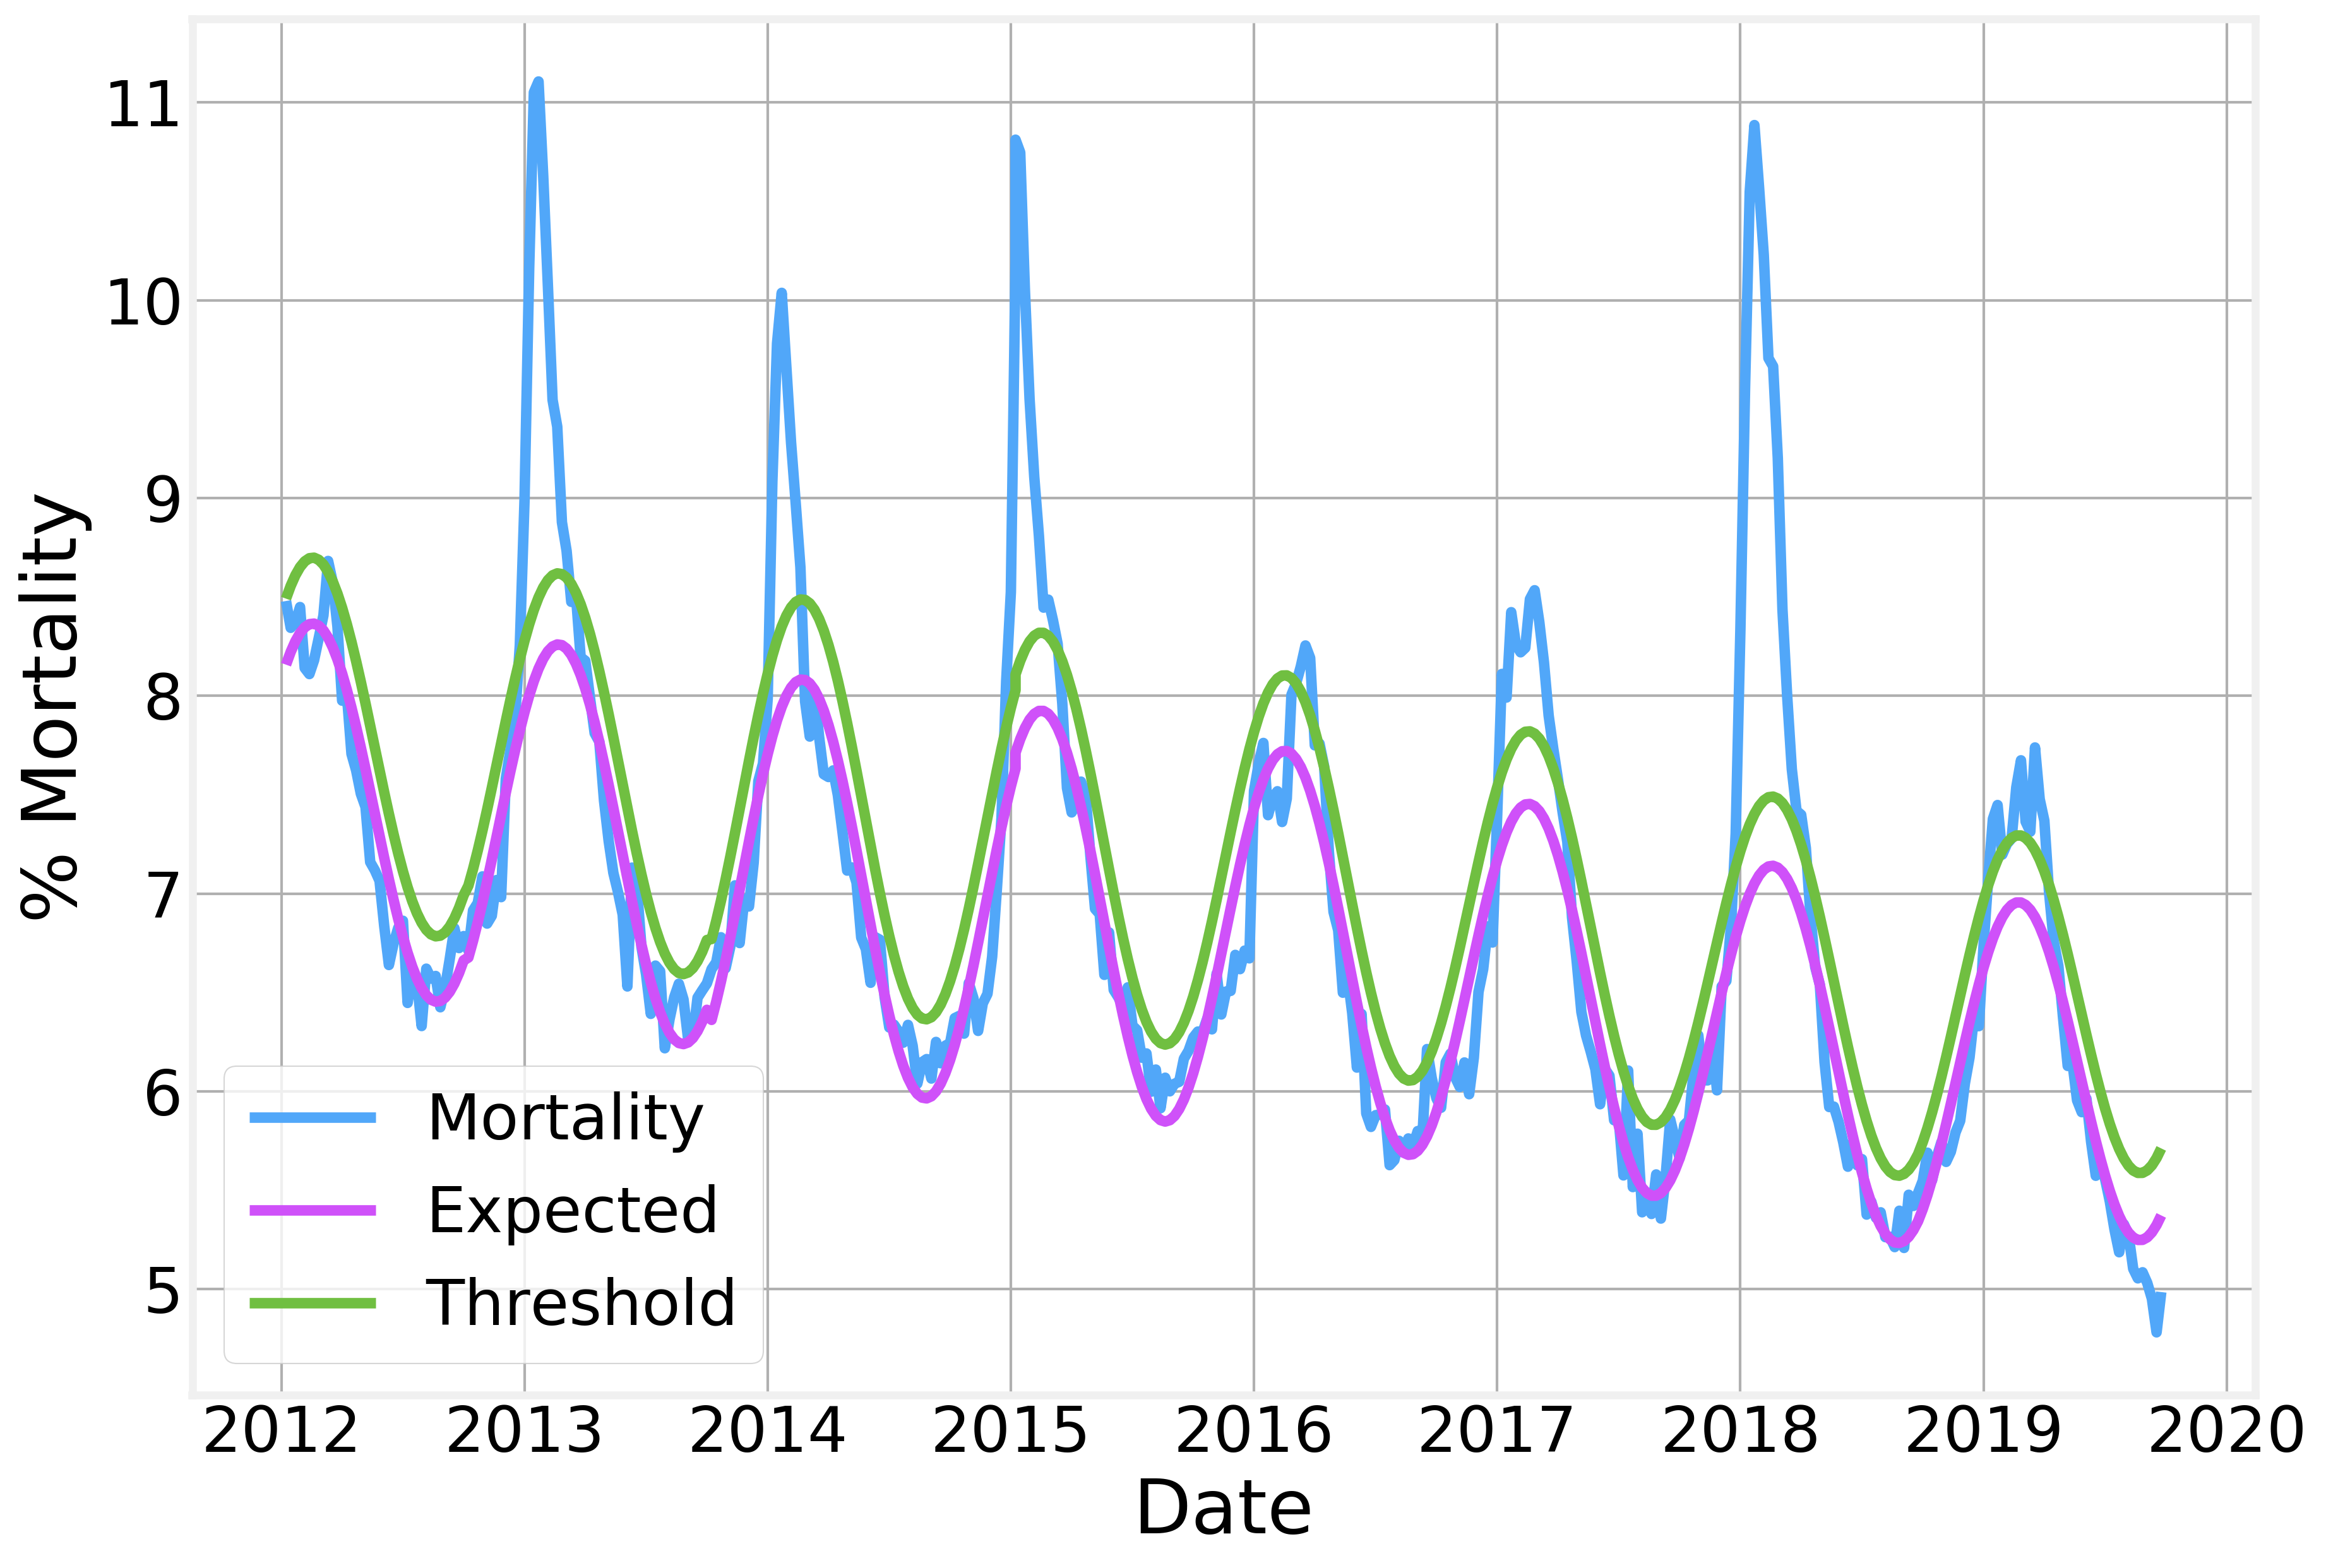

In [18]:
ILI.plot(x='date', y=['Percent of Deaths Due to Pneumonia and Influenza', 'Expected', 'Threshold'])
ax = plt.gca()
ax.legend(['Mortality', 'Expected', 'Threshold'])
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')

Calculate the FFT

In [19]:
signal = ILI['Percent of Deaths Due to Pneumonia and Influenza'].values
date = ILI['date']
N = len(signal)
fft_values = fft.fft(signal)

And the frequencies

In [20]:
freq_values = fft.fftfreq(N, 1/52) # 52 weeks per year

Plot the amplitude as a function of frequency 

Text(0, 0.5, 'Amplitude')

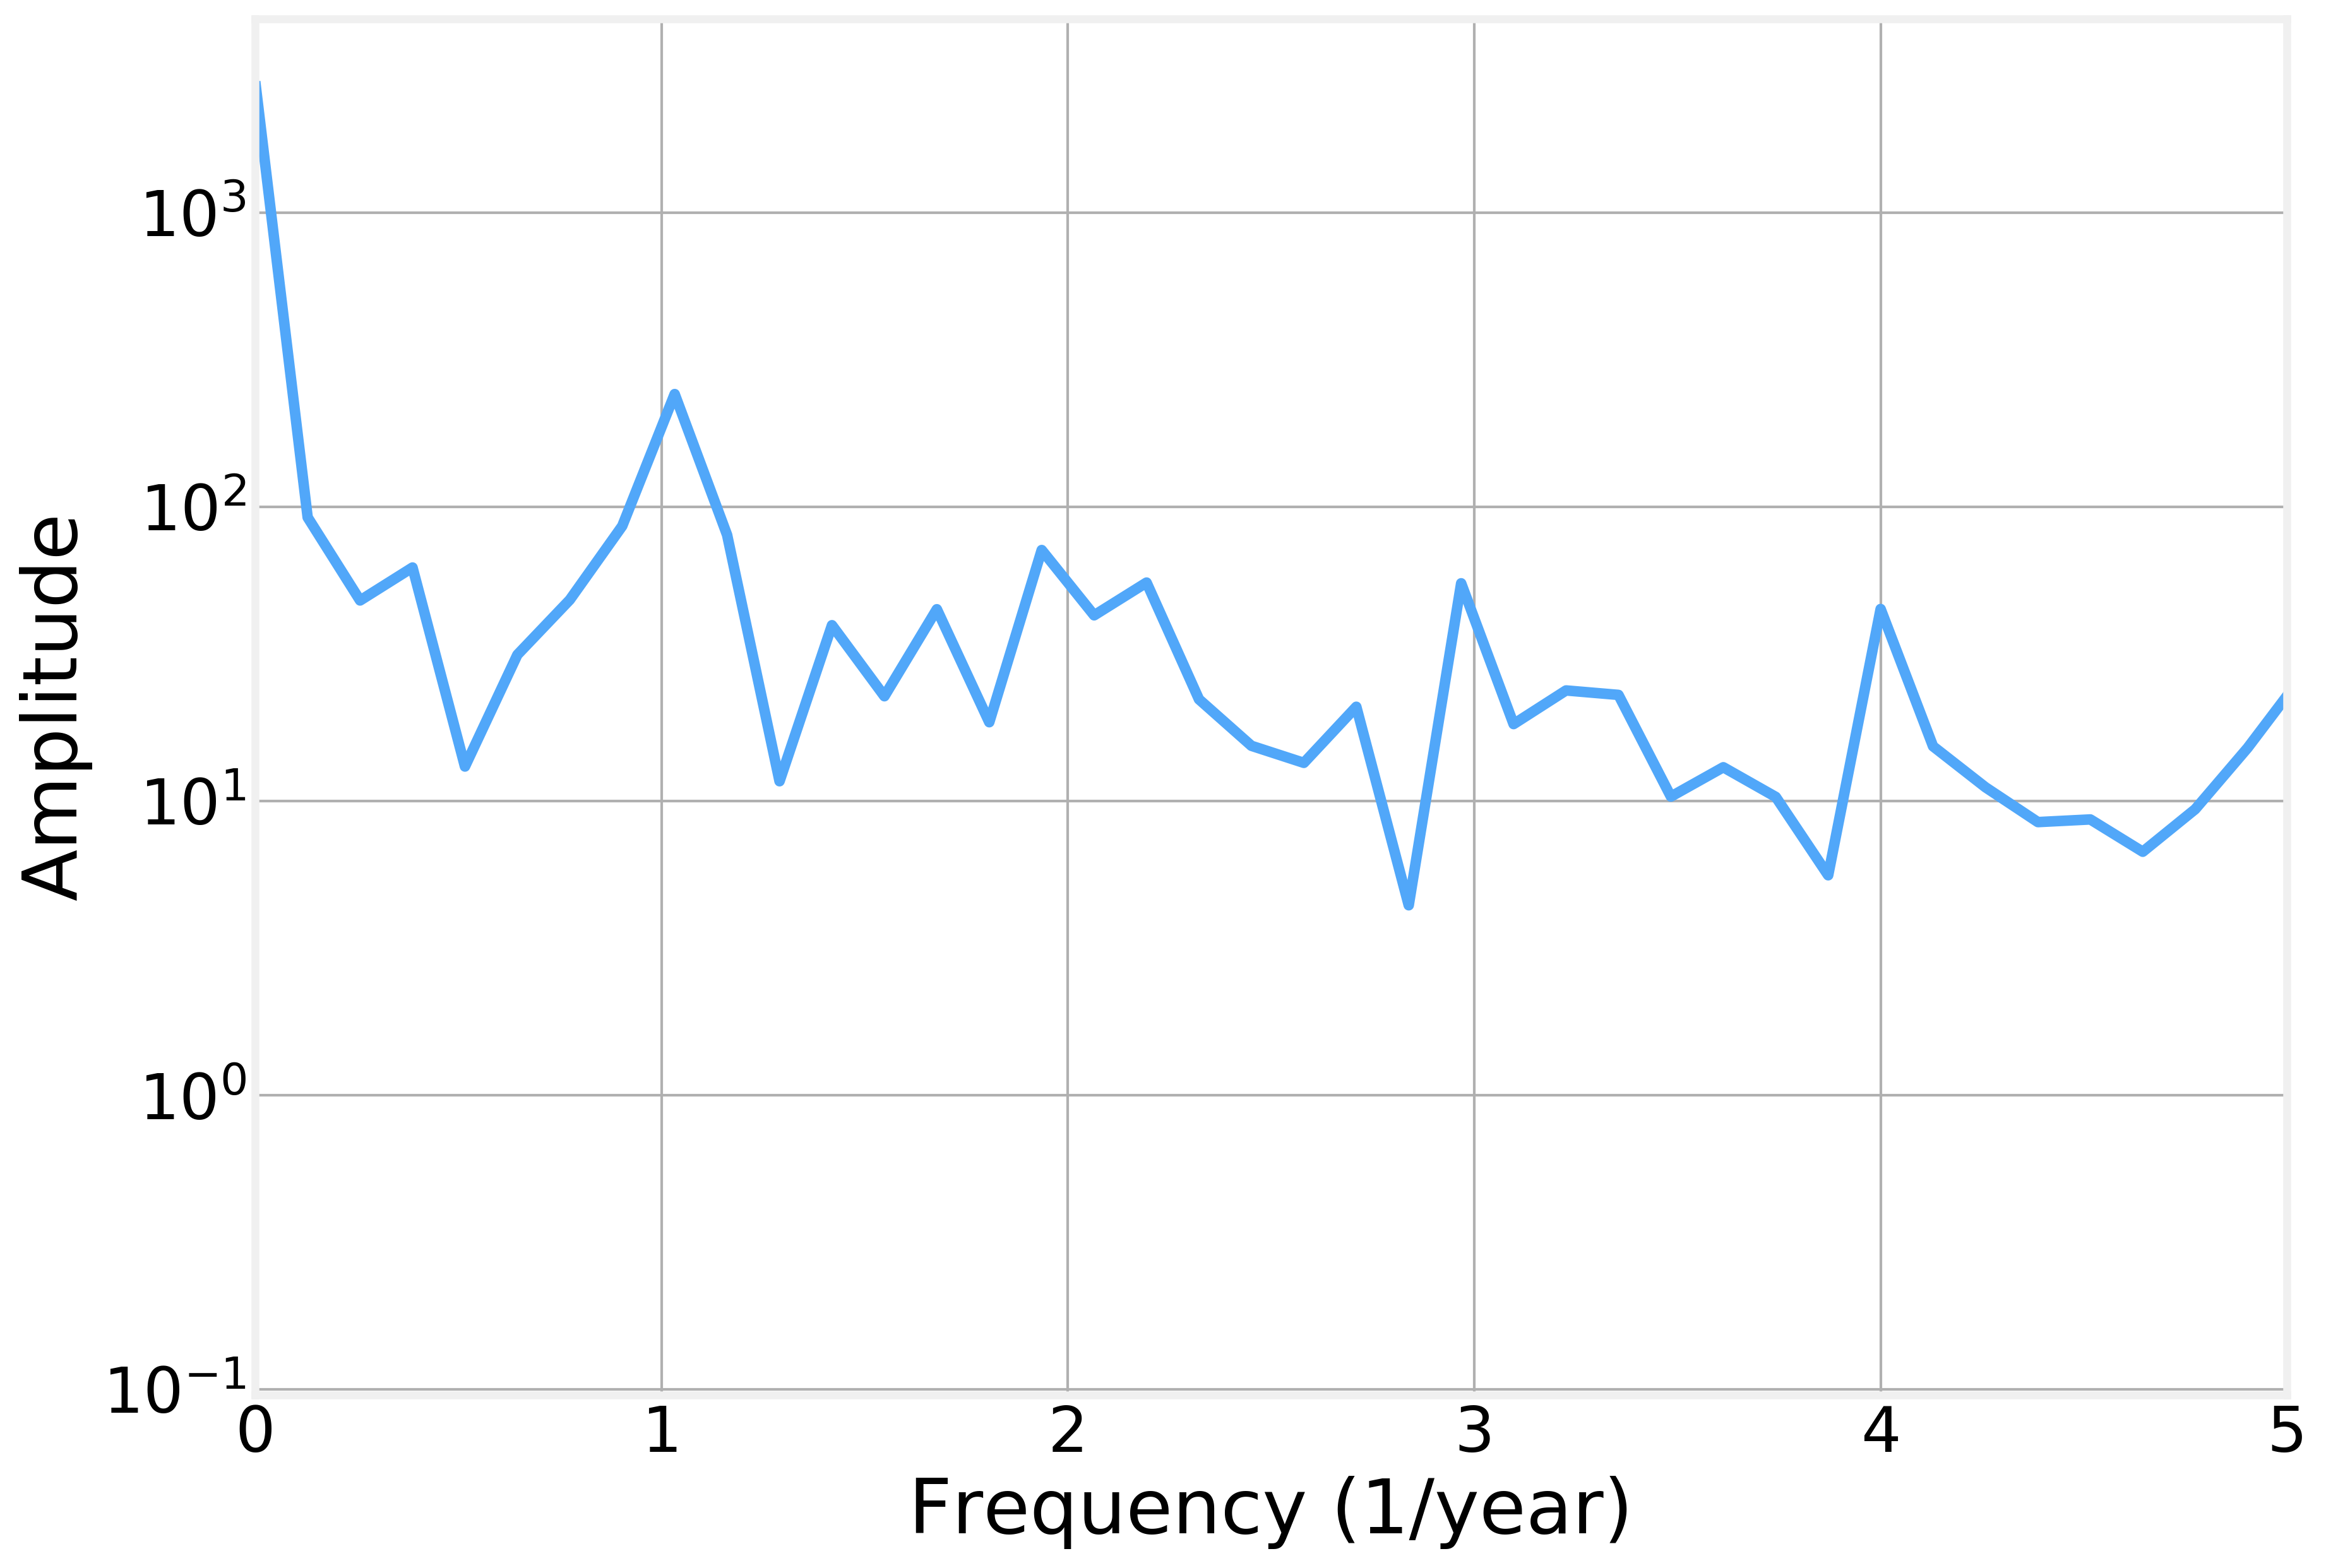

In [21]:
fig, ax = plt.subplots(1)
ax.semilogy(freq_values[:N//2], np.abs(fft_values[:N//2]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('Amplitude')

The frequency 0 component corresponds to a constant "level" after which the strongest component is ~1 year, indicating the yearly seasonality we had already identified. Higher freqencies have increasingly smaller Amplitudes indicating their decreasing importance.

We can remove some of the noise in the data by filtering out some of the higher frequencies. If we set every frequency higher than 2/year to zero

In [22]:
filtered = fft_values.copy()
filtered[np.abs(freq_values) > 2] = 0

And reconstrucing the original dataset using the filtered frequencies

In [23]:
signal_filtered = np.real(fft.ifft(filtered))

We obtain a cleaner version of the signal

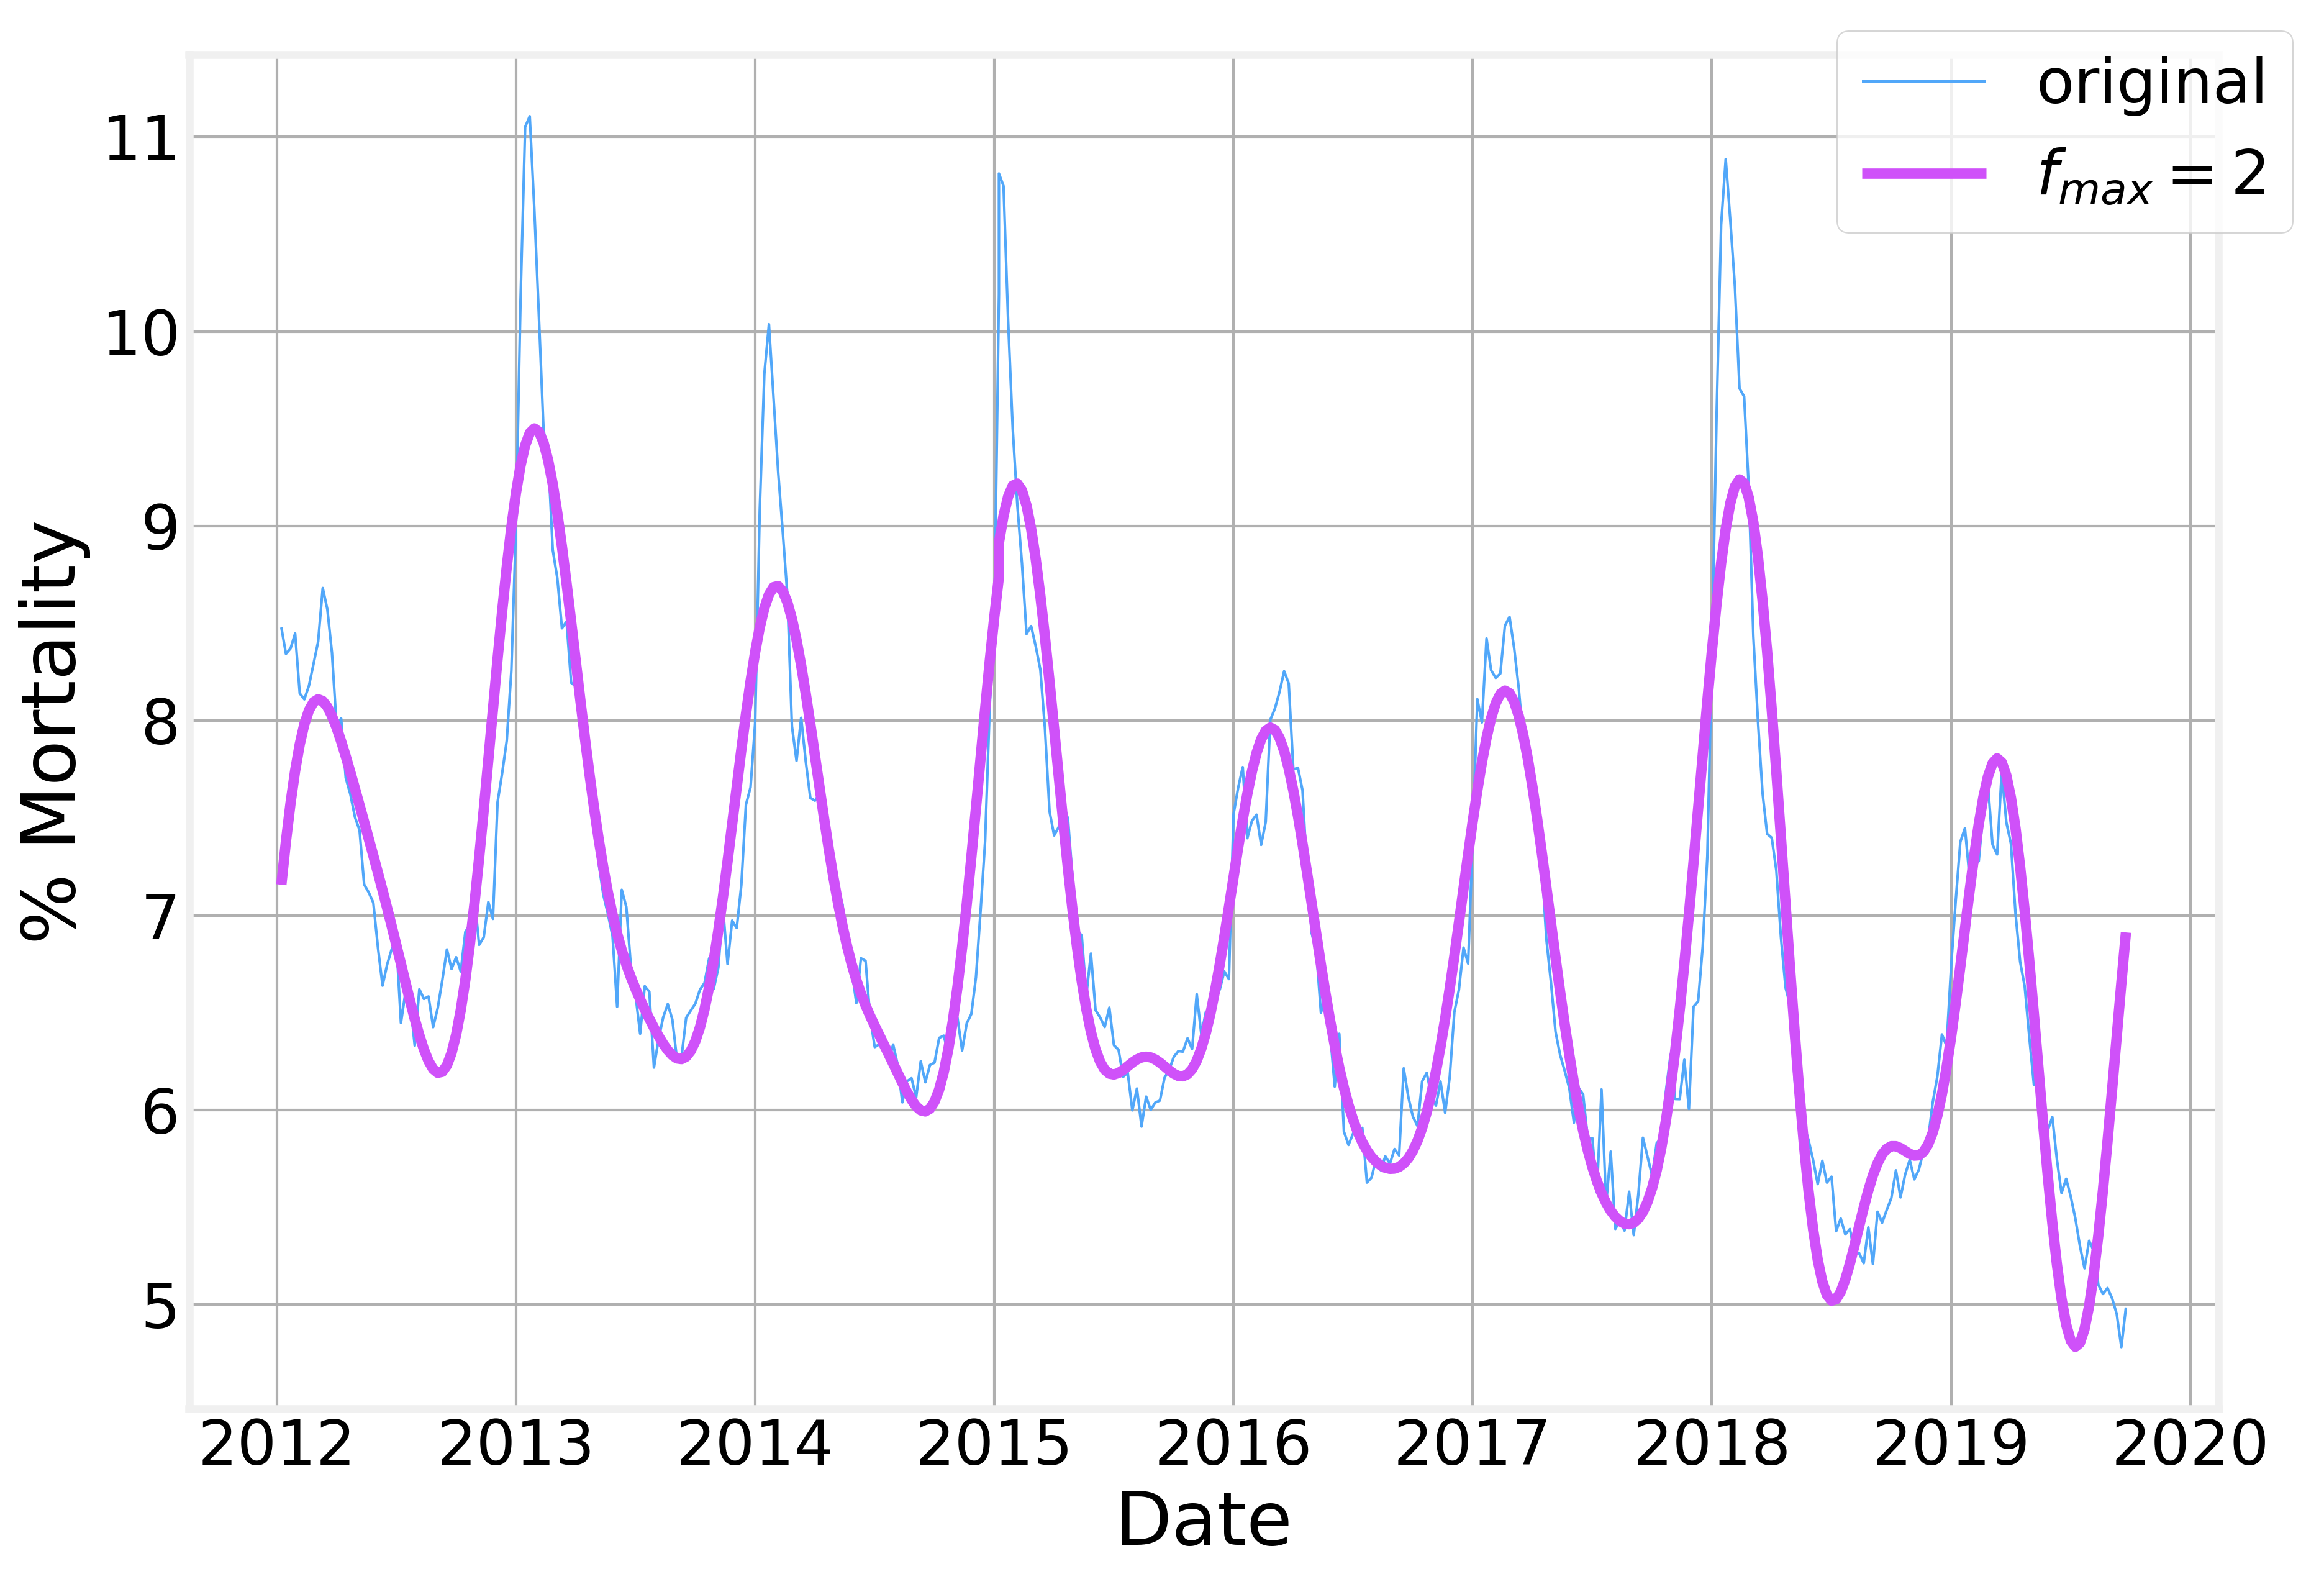

In [24]:
fig, ax = plt.subplots(1)
ax.plot(date, signal, lw=1, label='original')
ax.plot(date, signal_filtered, label=r'$f_{max}=2$')
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')
fig.legend()

Naturally, the more frequencies we include the closer we get to the original dataset

In [25]:
filtered2 = fft_values.copy()
filtered2[np.abs(freq_values) > 4] = 0
signal_filtered2 = np.real(fft.ifft(filtered2))

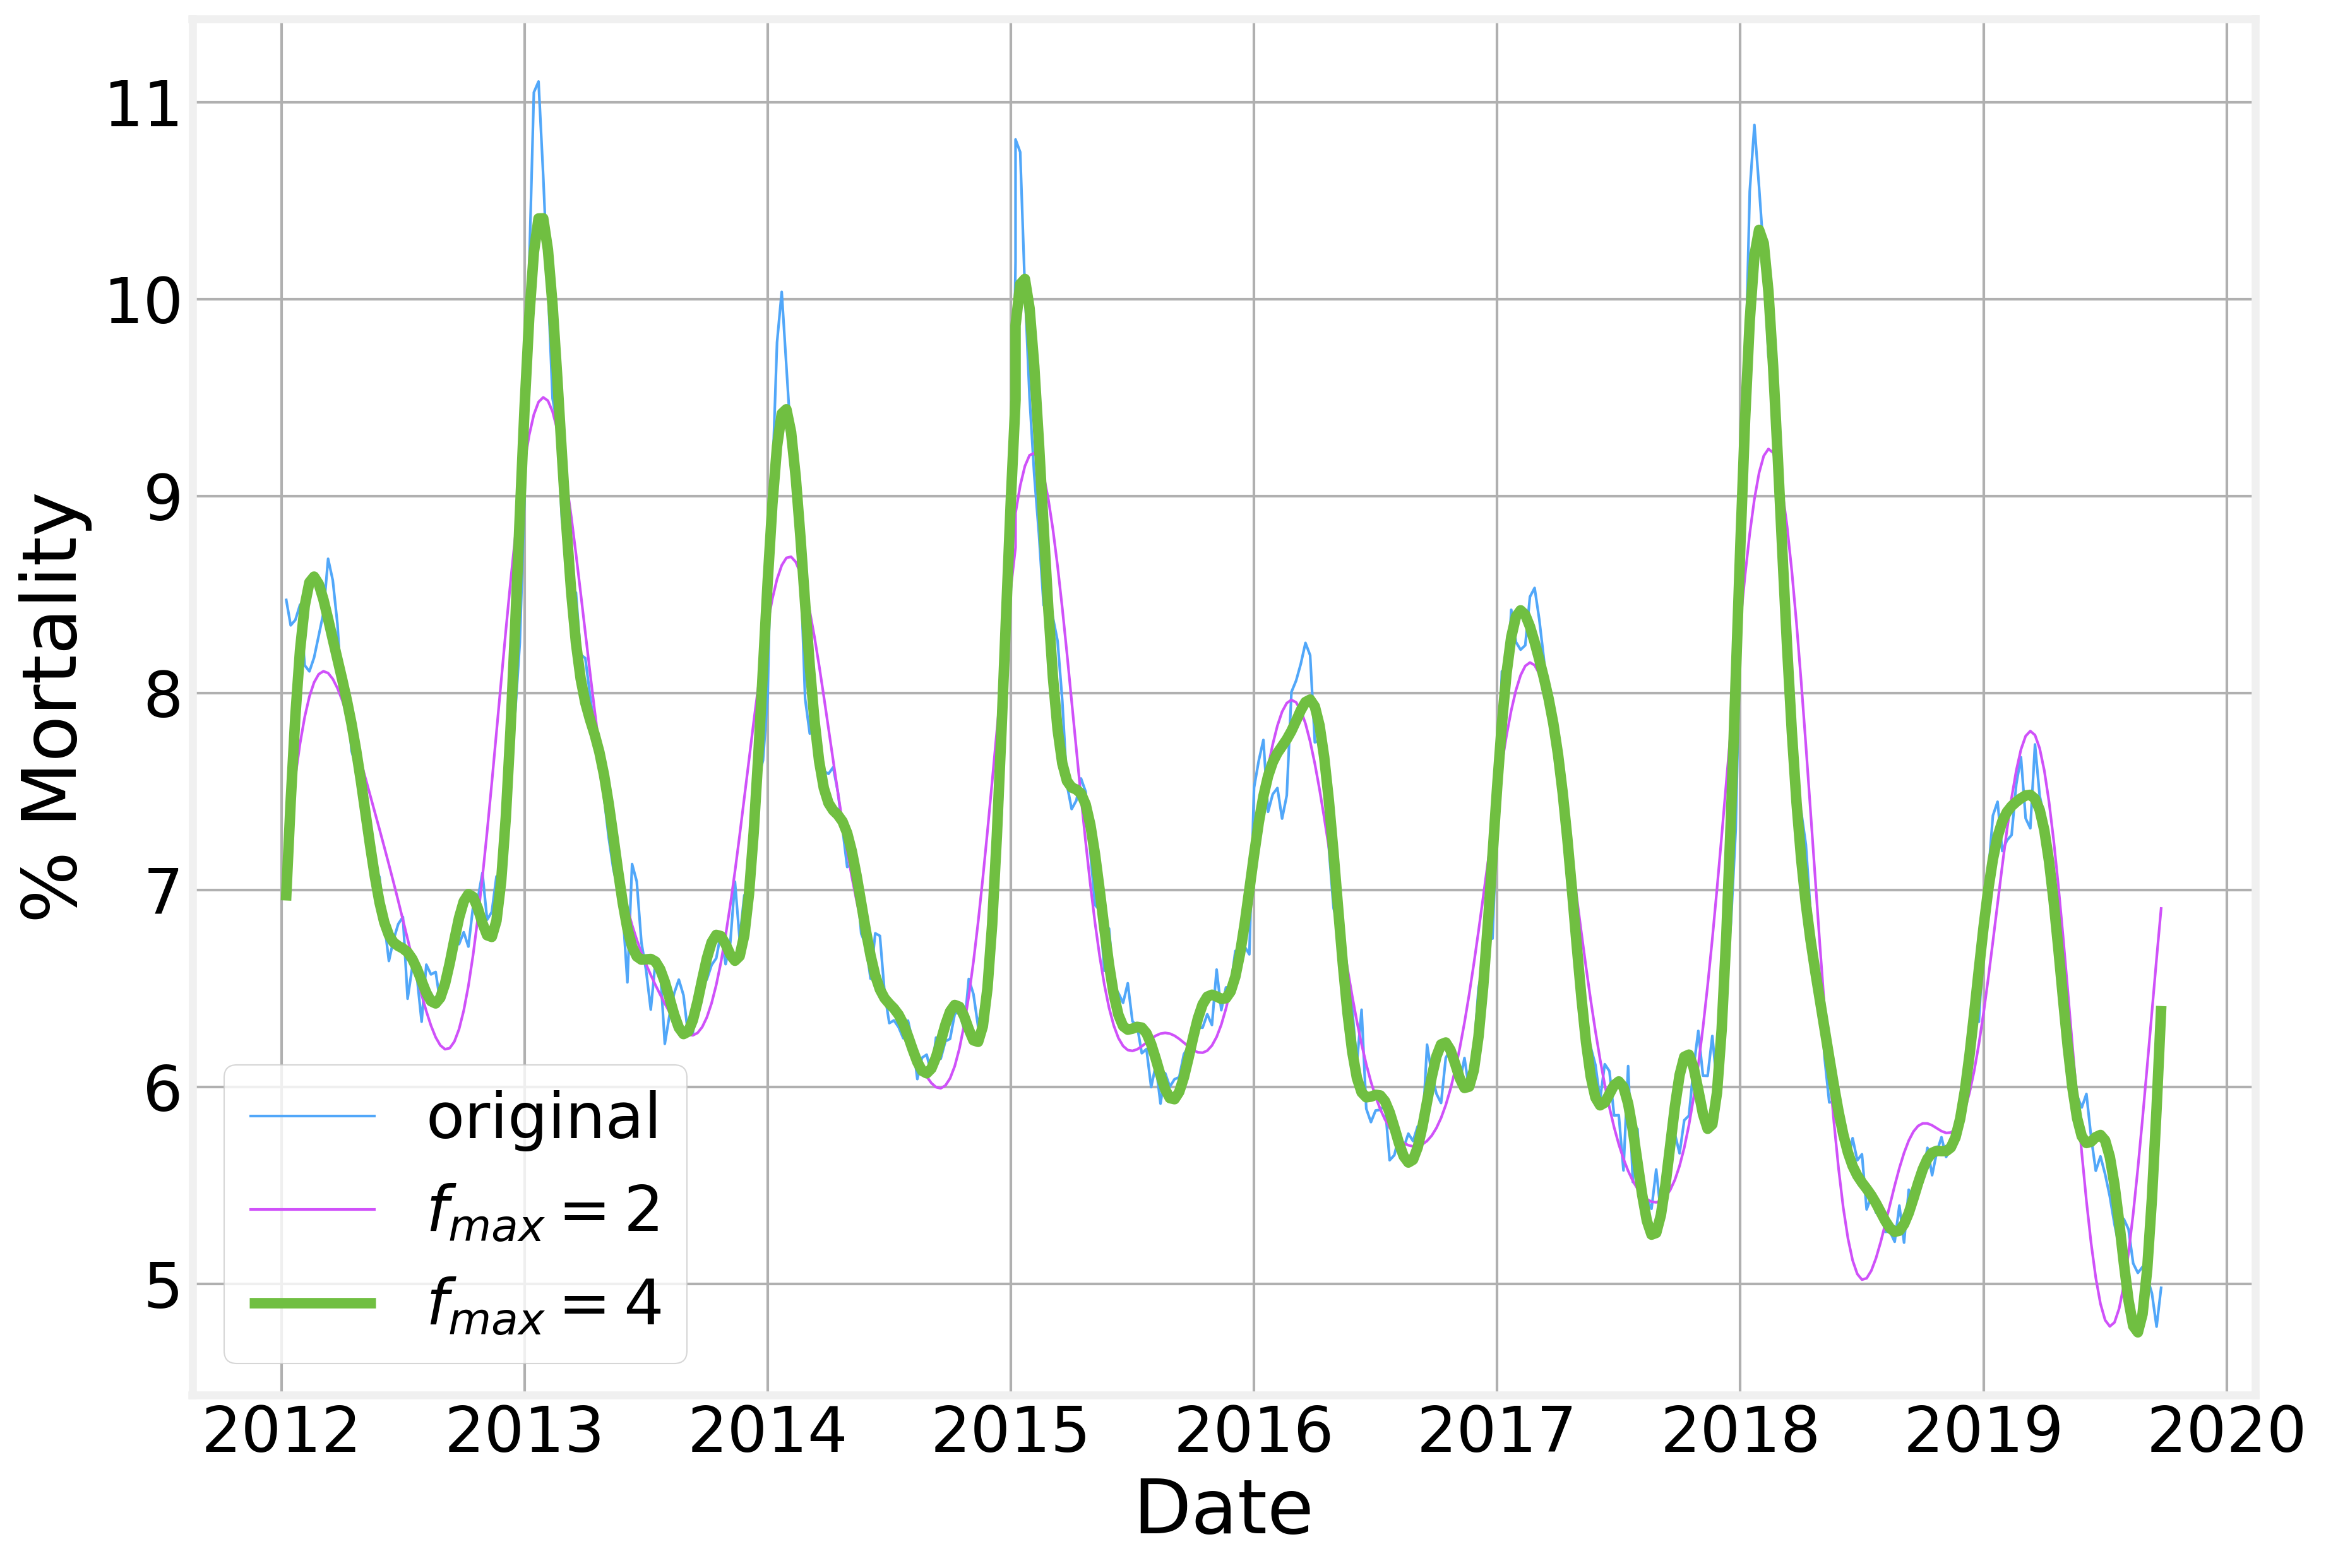

In [26]:
fig, ax = plt.subplots(1)
ax.plot(date, signal, lw=1, label='original')
ax.plot(date, signal_filtered, lw=1, label=r'$f_{max}=2$')
ax.plot(date, signal_filtered2, label=r'$f_{max}=4$')
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')
plt.legend()

## Extrapolation

As we saw above, we can rebuild the signal from the individual components.

$$ f\left(t\right)=\sum_k A_k\cos\left(2\pi\omega_k t + \phi_k\right) $$

where $A_k$ and $\omega_k$ are the amplitudes and frequencies for each frequency $k$ and $t$ is time vector. Since, in general, we have a complex FFT, we must explicitly add the phase component, $\phi_k$.

In principle, there's nothing preventing us from using a **longer** time vector than the one in the original dataset

In [27]:
N = len(signal)

fft_values = fft.fft(signal)
freq_values = fft.fftfreq(N)

# We're going to extend the signal for N time steps
time = np.arange(0, 2*N)
rebuilt = np.zeros(2*N)

for i, value in enumerate(filtered): 
    ampli = np.absolute(value)   
    phase = np.angle(value)
    rebuilt += ampli * np.cos(2 * np.pi * freq_values[i] * time + phase)

rebuilt /= N

Now let's compare the original signal with filtered and extended one

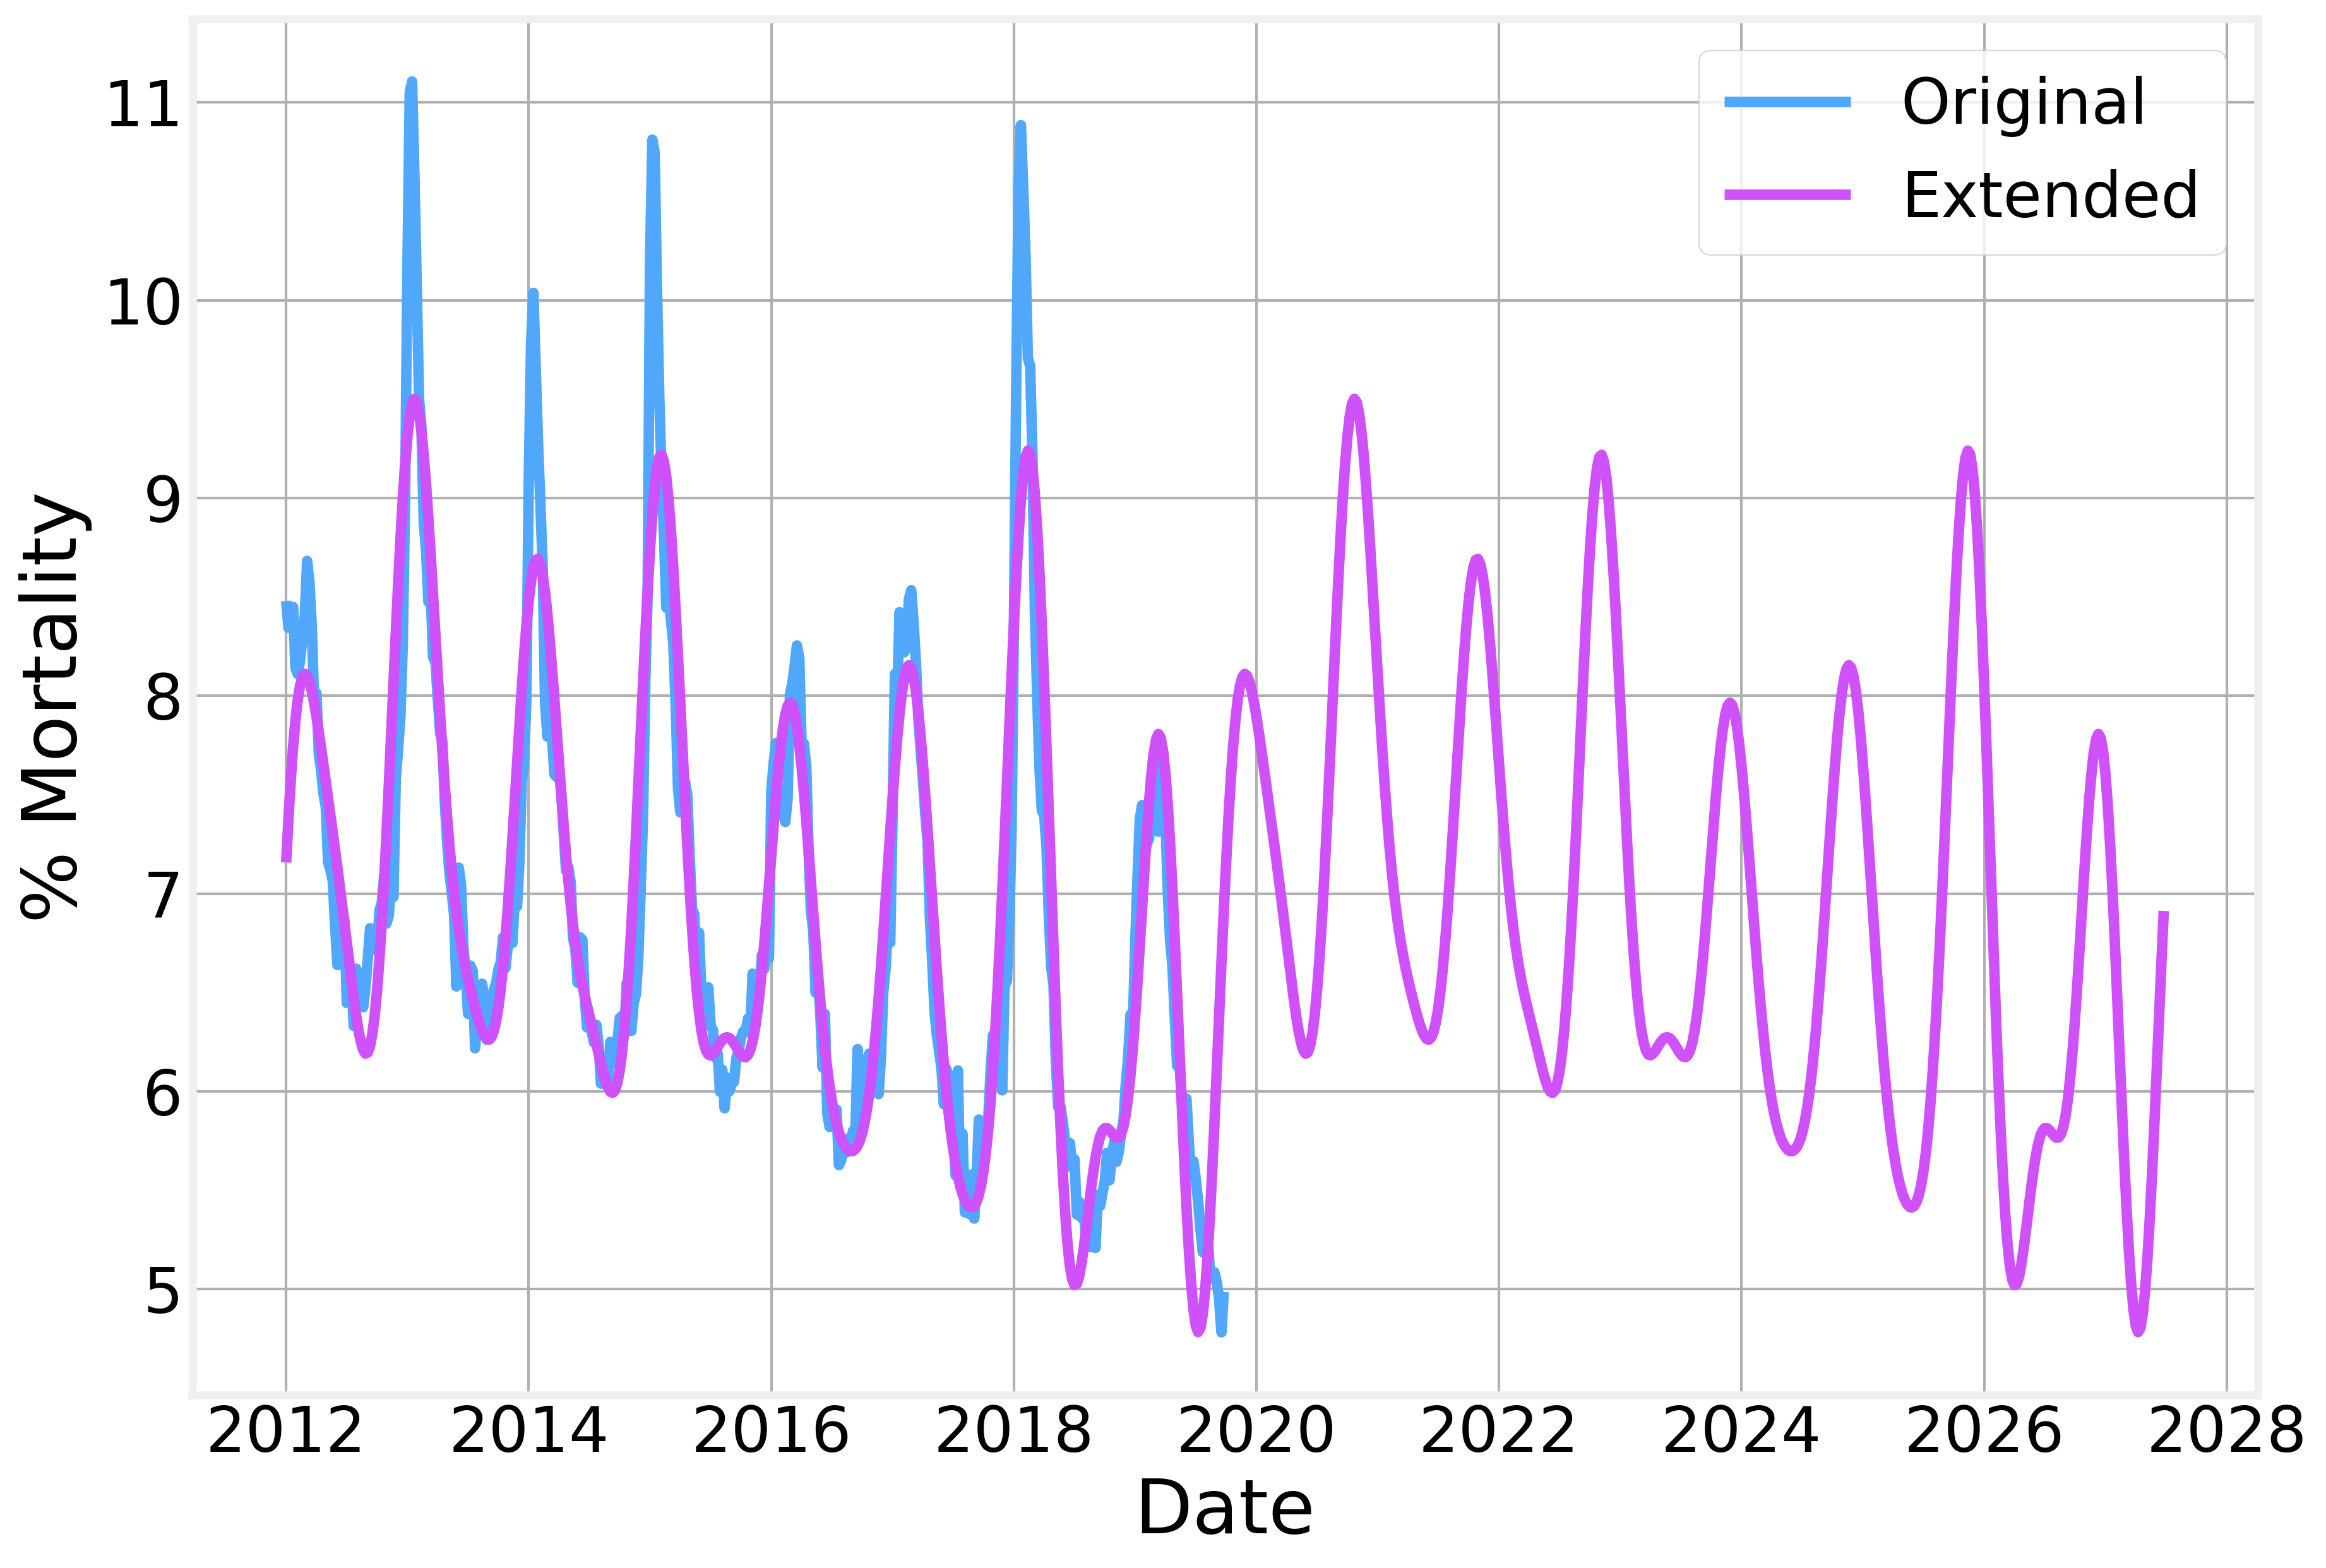

In [28]:
fig, ax = plt.subplots(1)
ax.plot(time[:N]/52+2012, signal, label='Original')
ax.plot(time/52+2012, rebuilt, label='Extended')
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')
ax.legend()

### Question

Do you notice something strange about the extrapolation?

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>